In [1]:
from liblibra_core import *
import matplotlib.pyplot as plt
import random
import numpy as np
from scipy.stats import gaussian_kde
#from sklearn.neighbors import NearestNeighbors
from scipy.special import digamma
from math import log, pi, gamma
import math

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for std::vector<std::vector<float, std::allocator<float> >, std::allocator<std::vector<float, std::allocator<float> > > > already registered; second conversion method ignored.
<frozen importlib._bootstrap>:241: RuntimeWar

# 1. Imagine we have just 2 methods

In [2]:
t, ELO_A, ELO_B = [], [], []

RA = 1500
RB = 1500

for i in range(10000): # how many games 
    t.append(i)
    ELO_A.append(RA)
    ELO_B.append(RB)
    
    ksi = random.uniform(0.0, 1.0)
    SA, SB = 0.0, 0.0
    if ksi<0.5:
        SA, SB = 1.0, 0.0
    else:
        SA, SB = 0.0, 1.0

    EA = 1.0/(1.0 + math.pow(10, (RB-RA)/400.0) )
    EB = 1.0/(1.0 + math.pow(10, (RA-RB)/400.0) )

    # Updates:
    K = 10.0
    RA_new = RA + K*(SA - EA)
    RB_new = RB + K*(SB - EB)
    RA = RA_new
    RB = RB_new

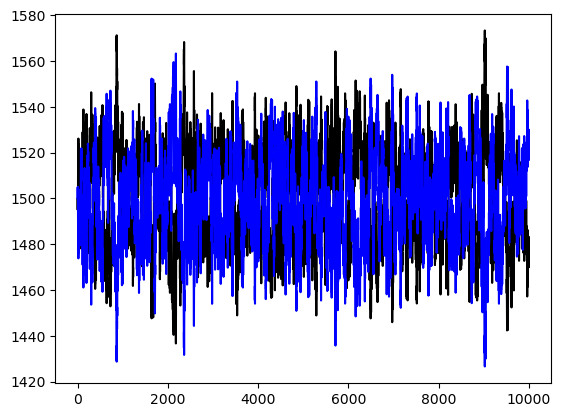

In [3]:
plt.plot(t, ELO_A, color="black")
plt.plot(t, ELO_B, color="blue")

# 2. Let's say we now have 3 methods and we need to pick the pairs

In [4]:
def elo_update(RA, RB, SA, SB):

    # Expected outcomes
    EA = 1.0/(1.0 + math.pow(10, (RB-RA)/400.0) )
    EB = 1.0/(1.0 + math.pow(10, (RA-RB)/400.0) )

    # Updates:
    K = 10.0
    RA_new = RA + K*(SA - EA)
    RB_new = RB + K*(SB - EB)

    return RA_new, RB_new

# Let's say A > B > C
win_matrix = np.array( [ [0.0, 1.0, 1.0],
                         [0.0, 0.0, 1.0],
                         [0.0, 0.0, 0.0] ] )
elo = np.array( [ 1000.0, 1000.0, 1000.0])
t, ELO_A, ELO_B, ELO_C = [], [], [], []


for i in range(50000): # how many games 
    t.append(i)
    ksi = random.uniform(0.0, 1.0)

    # select each pair with the same probability
    if ksi>0.0 and ksi<0.33:
        a, b = 0, 1
    elif ksi>0.33 and ksi<0.66:
        a, b = 0, 2
    else:
        a, b = 1, 2

    ELO_A.append(elo[0])
    ELO_B.append(elo[1])
    ELO_C.append(elo[2])
    
    elo[a], elo[b] = elo_update(elo[a],elo[b], win_matrix[a, b], win_matrix[b, a])


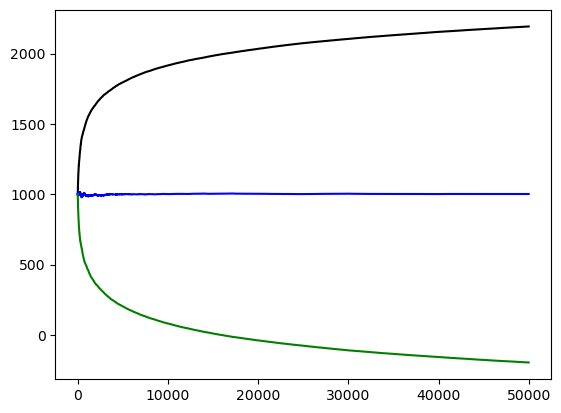

In [5]:
plt.plot(t, ELO_A, color="black")
plt.plot(t, ELO_B, color="blue")
plt.plot(t, ELO_C, color="green")

Conclusion - in this case, the ELOs will be unbound and do not converge - need to select pairs according to ELOs

## So here is ChatGPT's code to do ths - the key is the random sampling of matches

In [6]:
#import numpy as np

def compute_elo_from_matrix(W, K=32, base_rating=1500, max_iter=100, seed=42):
    """
    Compute steady-state Elo ratings from a win/loss matrix.

    Parameters:
    - W: NxN numpy array, where W[i, j] = 1 if i beat j, 0 otherwise
    - K: Elo update coefficient
    - base_rating: initial rating for all players
    - max_iter: number of times to iterate over all matchups
    - seed: random seed for reproducibility

    Returns:
    - ratings: N-element numpy array of final Elo ratings
    """
    np.random.seed(seed)
    N = W.shape[0]
    ratings = np.full(N, base_rating, dtype=float)

    match_indices = np.argwhere(W + W.T > 0)  # all pairs who played

    all_ratings, t = [], []
    for iteration in range(max_iter):
        t.append(iteration)
        all_ratings.append( np.array(ratings) )
        
        np.random.shuffle(match_indices)
        for i, j in match_indices:
            if W[i, j] == 0 and W[j, i] == 0:
                continue  # no match played

            Ri, Rj = ratings[i], ratings[j]
            Ei = 1 / (1 + 10 ** ((Rj - Ri) / 400))  # expected score for i
            result = 1 if W[i, j] == 1 else 0       # 1 if i won, 0 if j won

            ratings[i] += K * (result - Ei)
            ratings[j] -= K * (result - Ei)

    all_ratings = np.array(all_ratings)
    return ratings, t, all_ratings

In [7]:
# 4 players, W[i][j] = 1 if i beat j
W = np.array([
    [0, 1, 1, 0],
    [0, 0, 1, 1],
    [0, 0, 0, 1],
    [1, 0, 0, 0]
])

ratings, t, all_ratings = compute_elo_from_matrix(W, K=32, max_iter=100)
for i, r in enumerate(ratings):
    print(f"Player {i}: Elo = {r:.1f}")

Player 0: Elo = 1604.4
Player 1: Elo = 1587.6
Player 2: Elo = 1410.0
Player 3: Elo = 1397.9


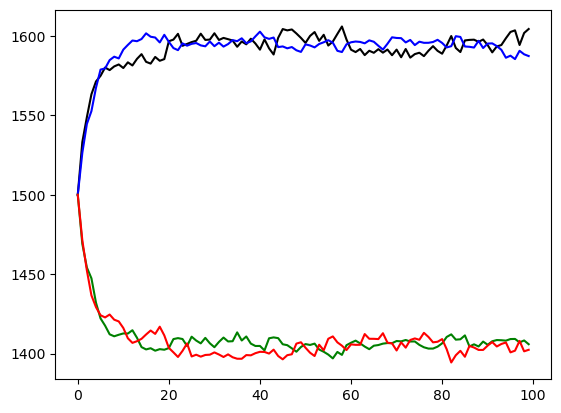

In [8]:
plt.plot(t, all_ratings[:, 0], color="black")
plt.plot(t, all_ratings[:, 1], color="blue")
plt.plot(t, all_ratings[:, 2], color="green")
plt.plot(t, all_ratings[:, 3], color="red")

# Time for a multidimensional Elo

In [9]:
#import numpy as np
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def multidim_elo(W, D=None, dim=3, K=0.1, base_scale=0.01, max_iter=100, seed=42):
    """
    Multidimensional Elo rating via SGD with dot-product based interaction.

    Parameters:
    - W: NxN win matrix (W[i,j] = number of wins i has over j)
    - D: NxN draw matrix (optional)
    - dim: number of dimensions for each player's rating
    - K: learning rate
    - base_scale: standard deviation for random init
    - max_iter: number of training passes
    - seed: RNG seed

    Returns:
    - ratings: NxD matrix of learned rating vectors
    """
    np.random.seed(seed)
    N = W.shape[0]
    if D is None:
        D = np.zeros_like(W)

    # Initialize player vectors randomly (small values)
    ratings = np.random.normal(loc=0.0, scale=base_scale, size=(N, dim))

    match_indices = np.argwhere(W + W.T + D > 0)

    for _ in range(max_iter):
        np.random.shuffle(match_indices)
        for i, j in match_indices:
            win_ij = W[i, j]
            win_ji = W[j, i]
            draw_ij = D[i, j]
            total = win_ij + win_ji + draw_ij
            if total == 0:
                continue

            # Actual result as average (win = 1, draw = 0.5, loss = 0)
            S_ij = (win_ij + 0.5 * draw_ij) / total

            # Predictive probability via dot product
            ri, rj = ratings[i], ratings[j]
            pred = sigmoid(np.dot(ri, rj))  # closer to 1 means i likely to win

            # Gradient step (chain rule on sigmoid)
            error = S_ij - pred
            grad = K * error * rj
            ratings[i] += grad
            ratings[j] += K * error * ri  # symmetric update

    return ratings

In [10]:
W = np.array([
    [0, 2, 1, 0],
    [1, 0, 3, 1],
    [2, 1, 0, 1],
    [3, 1, 2, 0]
])

D = np.array([
    [0, 0, 1, 1],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [1, 1, 0, 0]
])

ratings = multidim_elo(W, D, dim=3, K=0.1, max_iter=200)
for i, vec in enumerate(ratings):
    print(f"Player {i}: {vec}")

# Scalar "strengths":
np.linalg.norm(ratings, axis=1)

Player 0: [ 0.00497299 -0.00140822  0.00647478]
Player 1: [ 0.0151758  -0.00235796 -0.0023496 ]
Player 2: [ 0.01576504  0.00767678 -0.00468349]
Player 3: [ 0.00535814 -0.00463768 -0.00465527]


array([0.00828472, 0.01553659, 0.0181495 , 0.00847875])

# Multidimensional method - problem scoring via vector Elo with soft scores:

In [11]:
#import numpy as np
#import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from typing import Tuple

def generate_soft_score_data(M: int, P: int, dim: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate synthetic real-valued performance data between methods and problems.

    Parameters:
    - M: number of methods
    - P: number of problems
    - dim: dimension of latent space

    Returns:
    - S: M x P matrix of normalized soft scores in [0,1]
    - R_true: true method latent vectors
    - Q_true: true problem latent vectors
    """
    R_true = np.random.normal(0, 1, size=(M, dim))
    Q_true = np.random.normal(0, 1, size=(P, dim))
    
    logits = R_true @ Q_true.T
    scores = 1 / (1 + np.exp(-logits))  # sigmoid for probability-like soft scores
    return scores, R_true, Q_true

def train_soft_score_model(S: np.ndarray, dim: int = 3, K: float = 0.1, max_iter: int = 300) -> Tuple[np.ndarray, np.ndarray]:
    """
    Train method and problem embeddings using soft score matrix.

    Parameters:
    - S: M x P matrix of soft scores (real values in [0,1])
    - dim: number of dimensions in latent space
    - K: learning rate
    - max_iter: training iterations

    Returns:
    - R: M x dim learned method embeddings
    - Q: P x dim learned problem embeddings
    """
    M, P = S.shape
    R = np.random.normal(0, 0.1, size=(M, dim))
    Q = np.random.normal(0, 0.1, size=(P, dim))

    for _ in range(max_iter):
        for m in range(M):
            for p in range(P):
                pred_score = 1 / (1 + np.exp(-np.dot(R[m], Q[p])))
                error = S[m, p] - pred_score
                grad = error * pred_score * (1 - pred_score)  # derivative of sigmoid
                R[m] += K * grad * Q[p]
                Q[p] += K * grad * R[m]

    return R, Q

def plot_embeddings(R: np.ndarray, Q: np.ndarray):
    """
    Visualize method and problem embeddings projected to 2D with PCA.

    Parameters:
    - R: M x dim method matrix
    - Q: P x dim problem matrix
    """
    M = R.shape[0]
    P = Q.shape[0]
    combined = np.vstack([R, Q])
    labels = ['M' + str(i) for i in range(M)] + ['P' + str(j) for j in range(P)]
    colors = ['blue'] * M + ['red'] * P

    pca = PCA(n_components=2)
    proj = pca.fit_transform(combined)

    plt.figure(figsize=(8, 6))
    plt.scatter(proj[:, 0], proj[:, 1], c=colors, alpha=0.8)
    for i, txt in enumerate(labels):
        plt.text(proj[i, 0], proj[i, 1], txt, fontsize=8, ha='center', va='center')
    plt.title("Method vs. Problem Embeddings (Soft Scores, PCA)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid(True)
    plt.show()

In [12]:
M, P, dim = 10, 12, 5
S, R_true, Q_true = generate_soft_score_data(M, P, dim)
R_learned, Q_learned = train_soft_score_model(S, dim=dim, K=0.05, max_iter=300)

print("Soft score matrix (S):")
print(np.round(S, 2))
print("\nLearned method embedding (R):")
print(np.round(R_learned, 2))
print("\nLearned problem embedding (Q):")
print(np.round(Q_learned, 2))


Soft score matrix (S):
[[0.87 0.53 0.48 0.11 0.78 0.79 0.32 0.2  0.81 0.21 0.9  0.72]
 [0.99 0.93 0.06 0.04 0.28 0.82 0.09 0.06 0.8  0.01 0.96 1.  ]
 [0.11 0.14 0.88 0.57 0.86 0.2  0.82 0.38 0.84 0.97 0.61 0.02]
 [0.99 0.92 0.06 0.48 0.03 0.4  0.49 0.14 0.19 0.05 0.69 1.  ]
 [0.76 0.75 0.24 0.82 0.07 0.54 0.45 0.75 0.03 0.1  0.11 0.98]
 [0.   0.04 0.97 0.97 0.73 0.02 0.96 0.75 0.45 1.   0.07 0.  ]
 [0.18 0.57 0.39 0.82 0.49 0.82 0.4  0.96 0.25 0.6  0.08 0.11]
 [0.96 0.6  0.39 0.91 0.12 0.99 0.29 0.99 0.   0.01 0.01 1.  ]
 [0.66 0.64 0.32 0.49 0.57 0.8  0.41 0.75 0.61 0.49 0.47 0.33]
 [0.63 0.9  0.07 0.49 0.28 0.68 0.26 0.73 0.85 0.44 0.54 0.38]]

Learned method embedding (R):
[[-0.19  0.53 -0.67 -0.97 -0.34]
 [ 0.22  0.41 -0.49 -2.05  0.19]
 [-0.4   0.31 -0.87  1.28 -0.46]
 [ 1.11  0.53  0.5  -0.98  0.8 ]
 [ 0.47 -0.23  1.46 -0.36  0.52]
 [-0.17 -0.21  0.02  2.17 -0.27]
 [-0.29 -1.42  0.31  0.43  0.19]
 [ 0.11 -0.78  1.86 -0.59  0.4 ]
 [-0.44 -0.71 -0.13 -0.35 -0.11]
 [-0.26 -1.07 -0.4

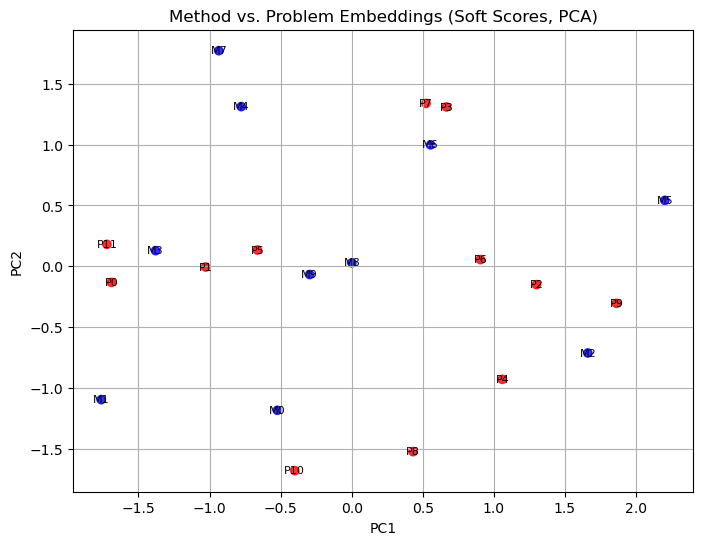

In [13]:
plot_embeddings(R_learned, Q_learned)

Notes:

* You can use this with real data (e.g., method performance on benchmark problems), as long as it's normalized to [0,1].

* You can change the activation function or loss if you want to model RMSE or ranking directly (e.g., replace sigmoid + MSE with hinge loss or log-loss).

* Learning rate K and iterations max_iter might need tuning for your data.


The PCA plot from the multidimensional Elo-like model shows a 2D projection of high-dimensional latent vectors for methods and problems. Here's how to interpret it:

* Each blue point = a method (e.g., algorithm, solver).

* Each red point = a problem (e.g., task, dataset).

* Vectors are learned from soft scores (e.g., success rates or normalized RMSE), with a logistic dot-product model.

The positions are projected into 2D using Principal Component Analysis (PCA) to preserve as much of the variance in the data as possible.

**Interpretation Guide**

1. **Proximity = Compatibility**

* A method close to a problem in 2D space likely performs well on it (high score).

* If a method and a problem are far apart, the method likely struggles on that problem.

2. **Clustering**

* Clusters of methods may indicate similar performance profiles (e.g., all are good on a certain subset of problems).

* Clusters of problems may represent problems with similar difficulty characteristics (relative to the method pool).

3. **Axes don’t have intrinsic meaning**

* PCA axes (PC1 and PC2) are linear combinations of original dimensions and aren't directly interpretable like Elo points.

* However, direction and spread along these axes reflect variance in performance style.

4. **Relative position > absolute position**

* The actual 2D coordinates don’t matter — it's the relative position of methods to problems that encodes meaning.

* Two methods close together likely perform similarly across problems.

# Implementing Balduzzi's mElo2

In [20]:
# melo_torch.py
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Optional, Tuple

class mElo(nn.Module):
    """
    Multidimensional Elo (mElo) model (Balduzzi et al. 2018).

    Each player i has two vectors U_i, V_i in R^k.
    The model predicts p(i beats j) = sigmoid( U_i^T V_j - U_j^T V_i ).

    Args:
        n_players: number of distinct players/agents
        k: embedding dimension
        device: 'cpu' or 'cuda'
        dtype: torch.float32 or float64
    """
    def __init__(self, n_players:int, k:int=2,
                 init_scale:float=0.1,
                 device:str='cpu',
                 dtype:torch.dtype=torch.float32):
        super().__init__()
        self.n_players = n_players
        self.k = k
        self.device = device
        self.dtype = dtype

        # U and V: shape (n_players, k)
        # initialize small random values
        self.U = nn.Parameter(torch.randn(n_players, k, dtype=dtype, device=device) * init_scale)
        self.V = nn.Parameter(torch.randn(n_players, k, dtype=dtype, device=device) * init_scale)

    def forward_logits(self, i_idx:torch.LongTensor, j_idx:torch.LongTensor) -> torch.Tensor:
        """
        Compute logits s = U_i^T V_j - U_j^T V_i for batch of matches.
        i_idx, j_idx: LongTensors of shape (batch,)
        returns logits shape (batch,)
        """
        # gather embeddings
        Ui = self.U[i_idx]      # (batch, k)
        Vj = self.V[j_idx]
        Uj = self.U[j_idx]
        Vi = self.V[i_idx]
        # dot products
        a = torch.sum(Ui * Vj, dim=-1)   # (batch,)
        b = torch.sum(Uj * Vi, dim=-1)
        logits = a - b
        return logits

    def predict_proba(self, i_idx:torch.LongTensor, j_idx:torch.LongTensor) -> torch.Tensor:
        """Return predicted probability that i beats j (sigmoid of logits)."""
        logits = self.forward_logits(i_idx, j_idx)
        return torch.sigmoid(logits)

    def bce_loss(self, i_idx:torch.LongTensor, j_idx:torch.LongTensor,
                 y:torch.Tensor, l2:float=0.0) -> torch.Tensor:
        """
        Binary cross-entropy loss for matches.
        y: tensor of 0/1 where 1 means i beat j.
        l2: weight decay on U and V (L2 regularization).
        """
        logits = self.forward_logits(i_idx, j_idx)
        loss = F.binary_cross_entropy_with_logits(logits, y.to(logits.dtype))
        if l2 > 0:
            loss = loss + 0.5 * l2 * (self.U.pow(2).sum() + self.V.pow(2).sum())
        return loss

def fit_melo(model: mElo,
             matches: torch.LongTensor,
             outcomes: torch.Tensor,
             *,
             batch_size: int = 1024,
             epochs: int = 10,
             lr: float = 1e-2,
             weight_decay: float = 0.0,
             shuffle: bool = True,
             device: Optional[str] = None,
             verbose: bool = True,
             scheduler: Optional[torch.optim.lr_scheduler._LRScheduler] = None,
             ) -> Tuple[mElo, dict]:
    """
    Train the model with mini-batch SGD (Adam by default).
    matches: LongTensor shape (N,2) where each row is (i_idx, j_idx)
    outcomes: FloatTensor shape (N,) with 1.0 if i wins, 0.0 otherwise
    """
    if device is None:
        device = model.device
    model.to(device)
    matches = matches.to(device)
    outcomes = outcomes.to(device).to(model.dtype)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)  # we apply L2 explicitly
    history = {'loss': []}
    N = matches.shape[0]
    idxs = torch.arange(N, device=device)

    for epoch in range(epochs):
        if shuffle:
            perm = torch.randperm(N, device=device)
        else:
            perm = idxs
        epoch_loss = 0.0
        n_seen = 0
        for start in range(0, N, batch_size):
            batch_idx = perm[start:start+batch_size]
            batch_matches = matches[batch_idx]            # (B,2)
            i_idx = batch_matches[:,0].long()
            j_idx = batch_matches[:,1].long()
            y = outcomes[batch_idx]

            optimizer.zero_grad()
            loss = model.bce_loss(i_idx, j_idx, y, l2=weight_decay)
            loss.backward()
            optimizer.step()

            epoch_loss += float(loss.detach()) * i_idx.shape[0]
            n_seen += i_idx.shape[0]

        if scheduler is not None:
            scheduler.step()

        avg_loss = epoch_loss / max(1, n_seen)
        history['loss'].append(avg_loss)
        if verbose:
            print(f"Epoch {epoch+1:3d}/{epochs:3d}  avg loss {avg_loss:.6f}")

    return model, history

# Utility: convert dataset (list of (i,j,outcome)) to tensors
def prepare_matches(pairs, n_players: Optional[int]=None, device='cpu'):
    """
    pairs: iterable of (i, j, outcome) where outcome is 1 if i beats j else 0.
    Returns matches LongTensor (N,2) and outcomes FloatTensor (N,).
    """
    data = list(pairs)
    matches = torch.LongTensor([[int(a), int(b)] for (a,b,c) in data], device=device)
    outcomes = torch.tensor([float(c) for (a,b,c) in data], dtype=torch.float32, device=device)
    return matches, outcomes


def elo_from_model(model, scale=400/math.log(10), base=1500):
    """
    Compute Elo-like scores for all players by averaging win probability
    against all others.
    """
    n = model.n_players
    idxs = torch.arange(n, device=model.U.device)
    scores = []
    for i in range(n):
        j = idxs[idxs != i]
        probs = model.predict_proba(
            i_idx=torch.full((len(j),), i, dtype=torch.long, device=model.U.device),
            j_idx=j
        )
        S_i = probs.mean().item()
        elo_i = scale * math.log(S_i / (1 - S_i)) + base
        scores.append(elo_i)
    return torch.tensor(scores)


In [17]:
def run():
    # small synthetic demo
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    n_players = 30
    k = 3
    model = mElo(n_players, k=k, device=device, dtype=torch.float32)

    # create synthetic "true" embeddings and simulate matches
    with torch.no_grad():
        true_U = torch.randn(n_players, k, device=device) * 1.0
        true_V = torch.randn(n_players, k, device=device) * 1.0

    def sim_prob(i,j):
        s = (true_U[i] @ true_V[j]) - (true_U[j] @ true_V[i])
        return torch.sigmoid(s).item()

    # generate matches
    import random
    matches_list = []
    for _ in range(5000):
        i = random.randrange(n_players)
        j = random.randrange(n_players)
        if i == j: 
            j = (j+1) % n_players
        p = sim_prob(i,j)
        outcome = 1 if random.random() < p else 0
        matches_list.append((i,j,outcome))

    matches, outcomes = prepare_matches(matches_list, device=device)

    # train
    model, history = fit_melo(model, matches, outcomes,
                             batch_size=512, epochs=50, lr=1e-2,
                             weight_decay=1e-4, device=device, verbose=True)
    return model


In [18]:
model = run()

Epoch   1/ 50  avg loss 0.690775
Epoch   2/ 50  avg loss 0.680399
Epoch   3/ 50  avg loss 0.659914
Epoch   4/ 50  avg loss 0.627627
Epoch   5/ 50  avg loss 0.587152
Epoch   6/ 50  avg loss 0.545834
Epoch   7/ 50  avg loss 0.511532
Epoch   8/ 50  avg loss 0.485469
Epoch   9/ 50  avg loss 0.466019
Epoch  10/ 50  avg loss 0.450567
Epoch  11/ 50  avg loss 0.437674
Epoch  12/ 50  avg loss 0.426752
Epoch  13/ 50  avg loss 0.416887
Epoch  14/ 50  avg loss 0.408658
Epoch  15/ 50  avg loss 0.401886
Epoch  16/ 50  avg loss 0.396462
Epoch  17/ 50  avg loss 0.392348
Epoch  18/ 50  avg loss 0.389164
Epoch  19/ 50  avg loss 0.387079
Epoch  20/ 50  avg loss 0.385252
Epoch  21/ 50  avg loss 0.383945
Epoch  22/ 50  avg loss 0.382984
Epoch  23/ 50  avg loss 0.382260
Epoch  24/ 50  avg loss 0.381526
Epoch  25/ 50  avg loss 0.381023
Epoch  26/ 50  avg loss 0.380646
Epoch  27/ 50  avg loss 0.380233
Epoch  28/ 50  avg loss 0.379844
Epoch  29/ 50  avg loss 0.379704
Epoch  30/ 50  avg loss 0.379347
Epoch  31/

In [21]:
elos = elo_from_model(model)
print(elos)

tensor([1510.0332, 1523.3687, 1525.6470, 1454.6992, 1492.7638, 1537.5969,
        1506.3682, 1532.2006, 1496.7068, 1485.6140, 1498.5894, 1480.4650,
        1468.6185, 1556.1455, 1519.0479, 1511.6100, 1478.2933, 1524.5963,
        1515.0078, 1457.8562, 1511.5038, 1525.9349, 1510.2373, 1474.8317,
        1457.6121, 1455.6525, 1469.8926, 1484.6198, 1493.6030, 1540.8252])
